In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *

import Pshirkov16  ## this contains procedures for Monte-Carlo simulation following Phsirkov e al. 2016


### Compare mean(redshift)
Here we validate the results of the numerical IGM simulation to analytical predictions by comparing the mean DM and RM and their redshift evolution.

In [2]:
## define analytical estimate

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from scipy import integrate


rho_crit = Planck15.critical_density0.value # g/cm3
omega_b = Planck15.Ob0
omega_m = Planck15.Om0
omega_L = Planck15.Ode0
m_p = 1.67e-24 # g
mu_e = 1.16
c = 2.99e8 # m/s
H_0 = 1./Planck15.hubble_time.value

n_e = rho_crit * omega_b  / m_p / mu_e

def DM(z, f_IGM=0.82):
    """ average DM as function of redshift from cosmic parameters (Planck15), assuming homogeneous IGM """
    return n_e * f_IGM *c/H_0* integrate.quad( lambda z: (1+z)/( omega_m*(1+z)**3 + omega_L )**0.5, 0, z)[0]
    

In [3]:
## initialize estimate following Pshirkov et al. 2016

## n_e = 1.8e-7 cm^-3 implicitly assumes ~83% of baryons in ionized IGM

B0 = 1e-4 # muG  at n_0=1.8e-7
l_c = 100 # Mpc    correlation length
z_max = 3.0

t0 = time()

LoS = Pshirkov16.Sightline( B0, l_c, z_max )
print('initialized in %.0f seconds' % (time() - t0))


initialized in 83 seconds


In [12]:
## perform Monte-Carlo simulation
t0 = time()
zs = LoS.zarray

N=1000

DMs = np.array([ LoS.DispersionMeasure( *LoS.CreateArrays( z_max, zarray=zs )[::-1] ) for i in range(N)])
print('%.0f seconds, now for the RM' % (time() - t0))
RMs = np.array([ np.abs(LoS.RotationMeasure( *LoS.CreateArrays( z_max, zarray=zs )[::-1])) for i in range(N)])
print('%.0f seconds, now for the plot' % (time() - t0))

195 seconds, now for the RM
389 seconds, now for the plot


In [13]:
## compute results

DM_mean_log = np.mean( np.log10(DMs), axis=0)
DM_mean = 10.**DM_mean_log
DM_std = np.std( np.log10(DMs), axis=0)
DM_err = np.array( [ DM_mean - 10.**(DM_mean_log-DM_std), 10**( DM_mean_log+DM_std) - DM_mean ] )
RM_mean_log = np.mean( np.log10(RMs), axis=0)
RM_mean = 10.**RM_mean_log
#RM_mean = np.mean( RMs, axis=0 )
RM_std = np.std( np.log10(RMs), axis=0)
RM_err = np.array( [ RM_mean - 10.**(RM_mean_log-RM_std), 10**( RM_mean_log+RM_std) - RM_mean ] )
#RM_mean = 10.**np.mean( np.log10(RMs), axis=0)
#RM_std = np.std( RMs, axis=0)

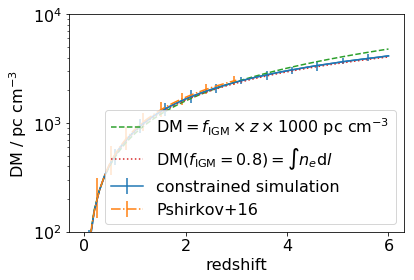

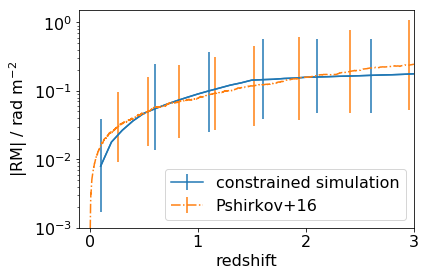

In [19]:
## plot and compare to other models


fig, ax = plt.subplots()

f_IGM = 0.8 ## IGM baryon content implicitly assumed by Pshirkov et al. 2016
scenario_IGM = { 'IGM': ['primordial_C%.0f' % (1000*f_IGM) ]} ## scenario considering only the IGM, using same f_IGM as Pshirkov

## first plot DM

## plot estimate of constrained simulation
PlotAverageEstimate( measure='DM', scenario=scenario_IGM, label='constrained simulation', ax=ax, errorevery=5)

## plot Pshirkov estimate
ax.errorbar( zs[:-1], DM_mean, yerr=DM_err, label='Pshirkov+16', errorevery=500, linestyle='-.')

## plot analytical predictions, see Hackstein et al. 2020
ax.plot( redshift_bins, redshift_bins*1000*f_IGM, label=r"DM$ = f_{\rm IGM} \times z \times 1000$ pc cm$^{-3}$", linestyle='--' )
ax.plot( redshift_bins, [DM(z , f_IGM=f_IGM ) for z in redshift_bins], label=r"DM$(f_{\rm IGM}=%.1f) = \int n_e {\rm d}l$" % f_IGM, linestyle=':' )



ax.set_ylim(1e2,1e4)
ax.legend(fontsize=16, loc=4)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()


## plot RM

fig, ax = plt.subplots()


## plot estimate of constrained simulation
PlotAverageEstimate( measure='RM', scenario=scenario_IGM, label='constrained simulation', ax=ax, errorevery=5)

## plot Pshirkov estimate
ax.errorbar( zs[:-1], RM_mean, yerr=RM_err, label='Pshirkov+16', errorevery=500, linestyle='-.')

ax.set_ylim(1e-3,1.5e0)
ax.set_xlim(-.1,3)
ax.legend(fontsize=16, loc=4)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()



The procedure to plot the average estimate of the constrained simulation can of course be used to plot the estimate of any scenario.

/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:176: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5


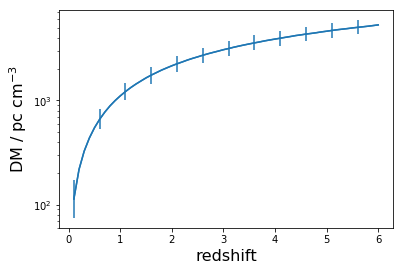

In [3]:
Properties = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18_wind'],
    'N_inter' : True
}

scenario = Scenario( redshift=0.1, **Properties) 

fig, ax = plt.subplots()

PlotAverageEstimate( measure='DM', scenario=scenario, label='intervening', errorevery=5, ax=ax)

plt.show()